In [1]:
import os
import time
import numpy as np
from tqdm import tqdm, trange
from collections import Counter, defaultdict
import pandas as pd
import random

import torch
import torchaudio
from torchaudio import transforms
from torchmetrics import F1Score
from torch.utils.data import DataLoader, Dataset, random_split

import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_path = 'data/'
categories = os.listdir(data_path)
paths_and_cats = defaultdict(list)

for i, category in enumerate(categories):
    
    audio_folder = f'{data_path}{category}/'
    audio_files = os.listdir(audio_folder)

    for audio_file in audio_files:
    
        file_path = f'{data_path}{category}/{audio_file}'
    
        if os.path.getsize(file_path) / (1024 * 1024) < 100:
        
            paths_and_cats['paths'].append(file_path)
            paths_and_cats['labels'].append(i)

print(Counter(paths_and_cats['labels']))
len(paths_and_cats['paths']), len(paths_and_cats['labels'])

Counter({0: 100, 1: 100, 2: 96, 3: 89})


(385, 385)

In [3]:
df = pd.DataFrame({"paths": paths_and_cats['paths'], 
                   "categories": paths_and_cats['labels']}).sample(frac=1).reset_index(drop=True)
df.head()

,paths,categories
0,data/history/3551.mp3,2
1,data/food/1932.mp3,1
2,data/art_music/2888.mp3,3
3,data/history/3579.mp3,2
4,data/art_music/2742.mp3,3


In [4]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.duration = 60
        self.new_freq = 16000
        self.top_db = 80
        self.n_fft = 1024
        self.n_mels = 128
            
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        audio_file = self.df.loc[idx, 'paths']
        class_id = self.df.loc[idx, 'categories']

        data, sr = torchaudio.load(audio_file)
        data = torchaudio.functional.resample(data, orig_freq=sr, new_freq=self.new_freq)
        sr = self.new_freq

        num_rows, sig_len = data.shape
        max_len = self.new_freq*self.duration
        if (sig_len > max_len):
            data = data[:,:max_len]
        elif (sig_len < max_len):
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            data = torch.cat((pad_begin, data, pad_end), 1)

        spec = transforms.MelSpectrogram(sr, n_fft=self.n_fft, hop_length=None, n_mels=self.n_mels)(data)
        return np.array(spec), class_id

In [5]:
custom_data = CustomDataset(df)

num_train = round(len(myds) * 0.8)
num_val = len(custom_data) - round(len(custom_data) * 0.8)
train_ds, val_ds = random_split(custom_data, [num_train, num_val])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

dataloaders = {'train': train_dl,
               'test': val_dl}

dataset_sizes = {'train': num_train,
                 'test': num_val}

dataset_sizes['train'], dataset_sizes['test']

(308, 77)

In [12]:
len(next(iter(dataloaders['train'])))

2

In [20]:
class CustomAudioClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        conv_layers += [self.conv1, self.relu1, self.bn1]
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        conv_layers += [self.conv2, self.relu2, self.bn2]

        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        conv_layers += [self.conv3, self.relu3, self.bn3]

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        conv_layers += [self.conv4, self.relu4, self.bn4]

        self.aap = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv = nn.Sequential(*conv_layers)
        self.lin = nn.Linear(in_features=64, out_features=4)


    def forward(self, x):
        x = self.conv(x)
        x = self.aap(x)
        x = x.view(x.shape[0], -1)
        x = self.lin(x)
        return x

In [26]:
N_Classes = 4

customModel = CustomAudioClassifierModel().to(device)

use_gpu = torch.cuda.is_available()

if use_gpu:
    customModel = customModel.cuda()

f1 = F1Score(num_classes=N_Classes, average="macro", task='multiclass')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(customModel.parameters(),lr=0.001)

In [27]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    best_model_wts = model.state_dict()
    best_f1 = 0.0
    losses = {'train': [], 'test': []}
    f1_macro = {'train': [], 'test': []}
    pbar = trange(num_epochs, desc='Epoch:')
    
    for epoch in pbar:
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train(True)
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            true_labels = []
            pred_labels = []
            
            for data in tqdm(dataloaders[phase], leave=False, desc=f'{phase} iter:'):
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels
                    
                if phase=='train':
                    optimizer.zero_grad()

                if phase == 'test':
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)
                true_labels +=  labels.tolist()
                pred_labels += outputs.tolist()

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item()

            epoch_loss = running_loss / dataset_sizes[phase]
            f1_score = f1(torch.tensor(pred_labels), torch.tensor(true_labels))
            losses[phase].append(epoch_loss)
            f1_macro[phase].append(f1_score)
            
            pbar.set_description('{} Loss: {:.4f} F1: {:.4f}'.format(
                                    phase, epoch_loss, f1_score
                                ))
            
            if phase == 'test' and f1_score > best_f1:
                best_f1 = f1_score
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test f1_macro: {:4f}'.format(best_f1))

    model.load_state_dict(best_model_wts)
    return model, losses, f1_macro

In [28]:
model, losses, f1_macro = train_model(customModel, criterion, optimizer, num_epochs=50)

test iter::  20%|██        | 1/5 [00:13<00:54, 13.52s/it]


train iter::  90%|█████████ | 18/20 [05:23<00:34, 17.15s/it]


train iter::  65%|██████▌   | 13/20 [03:31<01:53, 16.27s/it]


train iter::  40%|████      | 8/20 [02:13<03:10, 15.86s/it]


train iter::  15%|█▌        | 3/20 [00:52<05:05, 17.98s/it]


test Loss: 0.1583 F1: 0.3684: 100%|██████████| 50/50 [5:59:42<00:00, 431.65s/it] 

Training complete in 359m 42s
Best test f1_macro: 0.597658


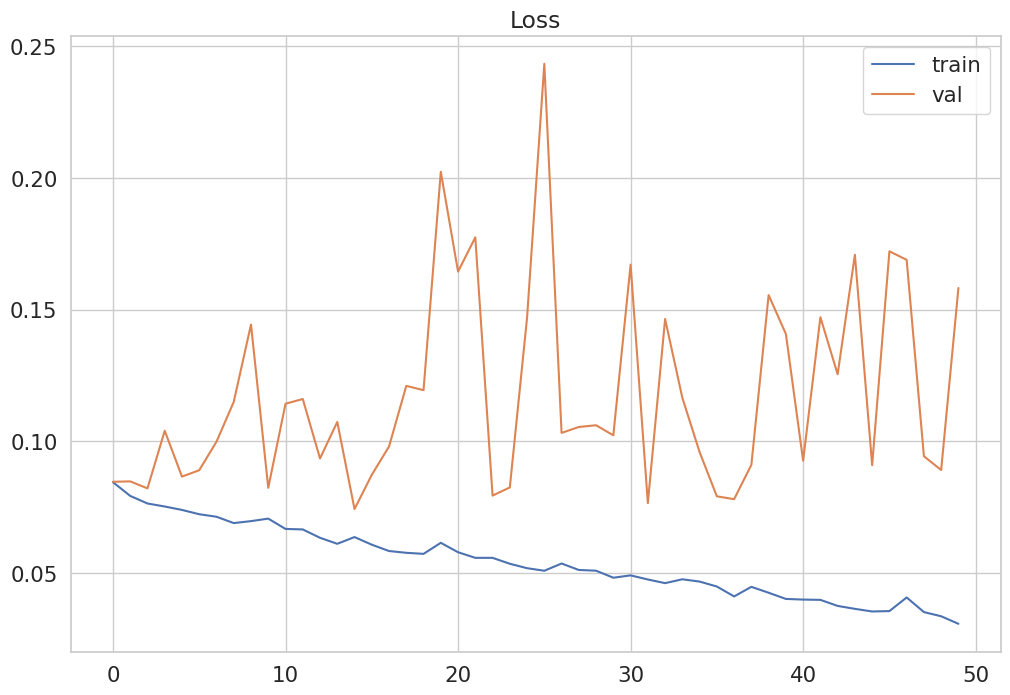

In [38]:
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['test'], label="val")
plt.title('Loss')
plt.legend()
plt.show()

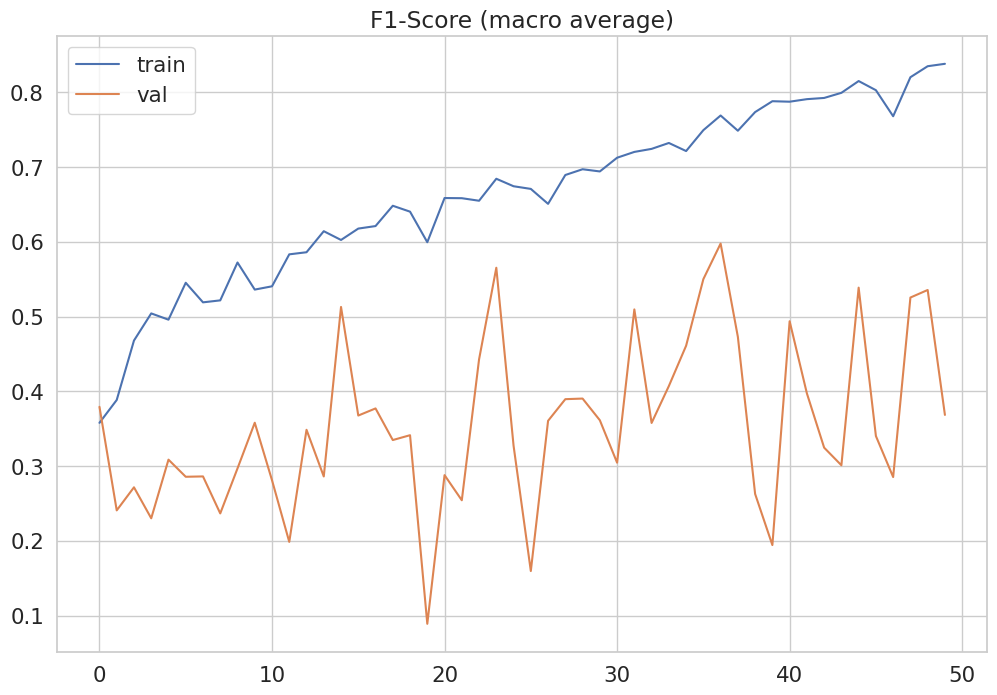

In [40]:
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(f1_macro['train'], label="train")
plt.plot(f1_macro['test'], label="val")
plt.title('F1-Score (macro average)')
plt.legend()
plt.show()